In [2]:
import numpy as np
import pandas as pd
import itertools
import os
import glob 
import threading
from numpy.polynomial import Polynomial
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time

Below, we define the corrections we want to apply, the size of the data chunks and the different path used to import data and save the light ones.

In [3]:
path_folder = '/kaggle/input/ariel-data-challenge-2024/' # path to the folder containing the data
path_out = '/kaggle/tmp/data_light_raw/' # path to the folder to store the light data
output_dir = '/kaggle/tmp/data_light_raw/' # path for the output directory

In [4]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

Directory /kaggle/tmp/data_light_raw/ created.


Data import:

The files are imported by chunks of size 'CHUNK_SIZE' to avoid exceeding the memory capacity.

In [5]:
CHUNKS_SIZE = 1

## Step 1: Analog-to-Digital Conversion

The Analog-to-Digital Conversion (adc) is performed by the detector to convert the pixel voltage into an integer number. We revert this operation by using the gain and offset for the calibration files 'train_adc_info.csv'.

In [6]:
def ADC_convert(signal, gain, offset):
    signal /= gain
    signal += offset
    return signal

## Step 2: Mask hot/dead pixel

The dead pixels map is a map of the pixels that do not respond to light and, thus, can’t be accounted for any calculation. In all these frames the dead pixels are masked using python masked arrays. The bad pixels are thus masked but left uncorrected. Some methods can be used to correct bad-pixels but this task, if needed, is left to the participants.

In [9]:
def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal, copy=False)
    signal = np.ma.masked_where(hot, signal, copy=False)
    return signal

**1. hot = sigma_clip(dark, sigma=5, maxiters=5).mask:**

* A função sigma_clip identifica pixels "quentes" no frame escuro (dark). Pixels quentes são pixels que produzem um sinal alto, mesmo quando o detector está fechado.
* Ela usa um critério de desvio padrão (sigma=5) para determinar quais pixels estão além de um limiar específico.
* maxiters=5 indica o número máximo de iterações que a função fará para identificar pixels outliers.
* .mask gera uma máscara booleana onde True indica os pixels identificados como quentes.

**2. dead = np.tile(dead, (signal.shape[0], 1, 1)):**

* O primeiro argumento de np.tile é dead, que tem o shape (32, 282).
* O segundo argumento é (signal.shape[0], 1, 1), que agora é (11250, 1, 1).
Neste caso, np.tile irá repetir a matriz dead 11250 vezes ao longo do primeiro eixo (número de observações). O 1 para o segundo e terceiro eixos significa que a matriz dead não será repetida ao longo das linhas e colunas.
Portanto, o resultado é uma matriz dead expandida com o shape (11250, 32, 282).

**3. hot = np.tile(hot, (signal.shape[0], 1, 1)):**

* O processo para hot é exatamente o mesmo que para dead. A matriz hot com shape (32, 282) será repetida 11250 vezes ao longo do primeiro eixo, resultando em uma matriz expandida com shape (11250, 32, 282).

**4. signal = np.ma.masked_where(dead, signal):**
* A *função np.ma.masked_where* cria um array mascarado (signal) onde os pixels indicados pela máscara dead são mascarados. Isso significa que esses pixels serão ignorados em análises posteriores.

**5. signal = np.ma.masked_where(hot, signal):**
* A função *np.ma.masked_where* também mascara os pixels quentes no sinal, usando a máscara hot expandida.

## Step 2: linearity Correction

**Non-linearity of pixels' response:**

The non-linearity of the pixels’ response can be explained as capacitive leakage on the readout electronics of each pixel during the integration time. The number of electrons in the well is proportional to the number of photons that hit the pixel, with a quantum efficiency coefficient. However, the response of the pixel is not linear with the number of electrons in the well. This effect can be described by a polynomial function of the number of electrons actually in the well. The data is provided with calibration files linear_corr.parquet that are the coefficients of the inverse polynomial function and can be used to correct this non-linearity effect.

In [25]:
linear_corr.shape

(6, 32, 282)

In [12]:
def apply_linear_corr(linear_corr,clean_signal):
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = Polynomial(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

A função apply_linear_corr corrige a não linearidade na resposta dos pixels do detector, usando informações de calibração contidas no arquivo *linear_corr.parquet*.

1. arregamento dos Coeficientes de Calibração:
    * A função recebe dois argumentos:
        * linear_corr: Um array NumPy com o shape (6, 32, 282) que contém os coeficientes do polinômio inverso usado para corrigir a não linearidade.
        * clean_signal: O sinal de entrada que você deseja corrigir, com o shape (11250, 32, 282).
2. Inversão dos Coeficientes:
    * linear_corr = np.flip(linear_corr, axis=0): A função np.flip inverte o array linear_corr ao longo do eixo 0, trocando a ordem dos coeficientes do polinômio. Isso é necessário porque os coeficientes estão geralmente armazenados em ordem inversa no arquivo de calibração.
3. Correção para Cada Pixel:
    * for x, y in itertools.product(range(clean_signal.shape[1]), range(clean_signal.shape[2])): O loop for itera sobre todos os pixels do sinal, usando itertools.product para gerar todas as combinações possíveis de x (linhas) e y (colunas).
    * poli = np.poly1d(linear_corr[:, x, y]): Para cada pixel, a função np.poly1d cria um polinômio usando os coeficientes de calibração linear_corr[:, x, y]. Esse polinômio representa a função inversa que corrige a não linearidade do pixel.
    * clean_signal[:, x, y] = poli(clean_signal[:, x, y]): A função polinomial poli é aplicada aos valores do sinal para cada pixel, corrigindo o efeito da não linearidade.
4. Retorno do Sinal Corrigido:
    * return clean_signal: A função retorna o sinal de entrada (clean_signal) após a aplicação da correção linear.

## Step 3: dark current subtraction

The data provided include calibration for dark current estimation, which can be used to pre-process the observations. Dark current represents a constant signal that accumulates in each pixel during the integration time, independent of the incoming light. To obtain the corrected image, the following conventional approach is applied: The data provided include calibration files such as dark frames or dead pixels' maps. They can be used to pre-process the observations. The dark frame is a map of the detector response to a very short exposure time, to correct for the dark current of the detector.

                                            image - dark * dt


The corrected image is conventionally obtained via the following: where the dark current map is first corrected for the dead pixel.

In [13]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark) # mascara os 'dead pixels' nos 'dark', os desconsiderando
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal

Do dark current both accumulate during **ground** and **wait** phase: 

* dt=(4.5 + 0.1) for AIRS
* dt=(0.1+0.1) for FGS

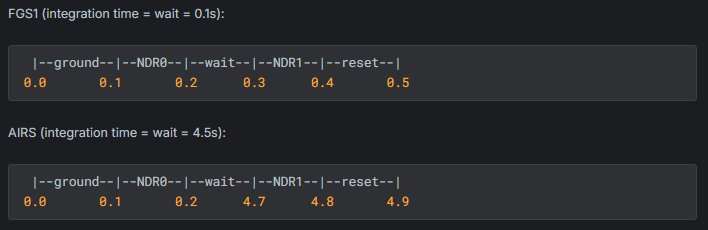

## Step 4: Get Correlated Double Sampling (CDS)

The science frames are alternating between the start of the exposure and the end of the exposure. The lecture scheme is a ramp with a double sampling, called Correlated Double Sampling (CDS), the detector is read twice, once at the start of the exposure and once at the end of the exposure. The final CDS is the difference (End of exposure) - (Start of exposure).

In [14]:
def get_cds(signal, cds):
    np.subtract(signal[:,1::2,:,:], signal[:,::2,:,:], out=cds)

## Step 5 (Optional): Time Binning

This step is performed mianly to save space. Time series observations are binned together at specified frequency.

In [15]:
def bin_obs(cds_signal,binning):
    cds_transposed = cds_signal.transpose(0,1,3,2)
    cds_binned = np.zeros((cds_transposed.shape[0], cds_transposed.shape[1]//binning, cds_transposed.shape[2], cds_transposed.shape[3]), dtype=np.float64)
    for i in range(cds_transposed.shape[1]//binning):
        cds_binned[:,i,:,:] = np.sum(cds_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    return cds_binned

## Step 6: Flat Field Correction

The flat field is a map of the detector response to uniform illumination, to correct for the pixel-to-pixel variations of the detector, for example the different quantum efficiencies of each pixel.

In [16]:
def correct_flat_field(flat,dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal

## Calibrating all training data

you can choose to correct the non-linearity of the pixels' response, to apply flat field, dark and dead map or to leave the data unchanged. The observations are binned in time by group of 30 frames for AIRS and 360 frames for FGS1, to obtain a lighter data-cube, easier to use. The images are cut along the wavelength axis between pixels 39 and 321, so that the 282 pixels left in the wavelength dimension match the last 282 targets' points, from AIRS. The 283rd targets' point is the one for FGS1 that will be added later on.

In [18]:
## we will start by getting the index of the training data:
def get_index(files,CHUNKS_SIZE):
    index = []
    for file in files :
        file_name = file.split('/')[-1]
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal.parquet':
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index) 
    index = np.array_split(index, len(index)//CHUNKS_SIZE)
    
    return index

#### Função para calibração dos dados

In [26]:
def calibrate_data(nthreads, thread_idx) :
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l), dtype=np.float64)
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32), dtype=np.float64)
        
    AIRS_cds = np.zeros((AIRS_CH0_clean.shape[0], AIRS_CH0_clean.shape[1]//2, AIRS_CH0_clean.shape[2], AIRS_CH0_clean.shape[3]))
    FGS1_cds = np.zeros((FGS1_clean.shape[0], FGS1_clean.shape[1]//2, FGS1_clean.shape[2], FGS1_clean.shape[3]))
    
    for n, index_chunk in tqdm(enumerate(index)):
        if n % nthreads != thread_idx:
            continue
            
        for i in range (CHUNKS_SIZE) : 
            df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
            signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
        
            gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
            offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
            signal = ADC_convert(signal, gain, offset)
            dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
            chopped_signal = signal[:, :, cut_inf:cut_sup]
            del df

            # CLEANING THE DATA: AIRS
            flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
            dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
            dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
            linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]

            if DO_MASK:
                chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
                AIRS_CH0_clean[i] = chopped_signal
            else:
                AIRS_CH0_clean[i] = chopped_signal

            if DO_THE_NL_CORR: 
                linear_corr_signal = apply_linear_corr(linear_corr,AIRS_CH0_clean[i])
                AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
            del linear_corr

            if DO_DARK: 
                cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
                AIRS_CH0_clean[i] = cleaned_signal
            else: 
                pass
            del dark

            df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
            fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))

            FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
            FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]

            fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
            dt_fgs1 = np.ones(len(fgs_signal))*0.1
            chopped_FGS1 = fgs_signal
            del fgs_signal, df

            # CLEANING THE DATA: FGS1
            flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
            dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
            dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
            linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))

            if DO_MASK:
                chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
                FGS1_clean[i] = chopped_FGS1
            else:
                FGS1_clean[i] = chopped_FGS1

            if DO_THE_NL_CORR: 
                linear_corr_signal = apply_linear_corr(linear_corr,FGS1_clean[i])
                FGS1_clean[i,:, :, :] = linear_corr_signal
            del linear_corr

            if DO_DARK: 
                cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
                FGS1_clean[i] = cleaned_signal
            else: 
                pass
            del dark

        # SAVE DATA AND FREE SPACE
        get_cds(AIRS_CH0_clean, AIRS_cds)
        get_cds(FGS1_clean, FGS1_cds)

        AIRS_CH0_clean.fill(0)
        FGS1_clean.fill(0)

        ## (Optional) Time Binning to reduce space
        if TIME_BINNING:
            AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
            FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
        else:
            AIRS_cds_binned = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
            FGS1_cds_binned = FGS1_cds.transpose(0,1,3,2)

        for i in range (CHUNKS_SIZE):
            flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
            flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
            if DO_FLAT:
                corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
                AIRS_cds_binned[i] = corrected_AIRS_cds_binned
                corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
                FGS1_cds_binned[i] = corrected_FGS1_cds_binned
            else:
                pass

        ## save data
        np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
        np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)

In [27]:
start_time = time.time()

files = glob.glob(os.path.join(path_folder + 'train/', '*/*'))

#index = get_index(files[:4],CHUNKS_SIZE)
index = get_index(files,CHUNKS_SIZE)  ## 48 is hardcoded here but please feel free to remove it if you want to do it for the entire dataset

train_adc_info = pd.read_csv(os.path.join(path_folder, 'train_adc_info.csv'))
train_adc_info = train_adc_info.set_index('planet_id')
axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))
DO_MASK = True
DO_THE_NL_CORR = True
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

#N = index.shape[0]
cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

nthreads = 4

calibration_start_time = time.time()

threads = []
for i in range(nthreads):
    threads.append(threading.Thread(target=calibrate_data, args=(nthreads, i,)))
    threads[i].start()

for t in threads:
    t.join()
    
calibration_end_time = time.time()

print(f"Tempo total de calibração: {calibration_end_time - calibration_start_time:.2f} segundos")

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]


3it [01:31, 30.55s/it]

4it [01:32, 23.13s/it]
1it [01:34, 94.08s/it]

8it [02:45, 20.27s/it]


7it [02:49, 23.25s/it]
5it [02:53, 30.93s/it]

11it [04:07, 21.51s/it]
9it [04:08, 24.21s/it]


10it [04:08, 23.02s/it]

15it [05:23, 20.46s/it]
13it [05:24, 21.93s/it]


14it [05:25, 21.34s/it]

19it [06:39, 19.94s/it]


18it [06:40, 20.41s/it]
17it [06:41, 20.89s/it]

23it [07:53, 19.40s/it]


22it [07:56, 19.89s/it]
21it [07:57, 20.19s/it]

27it [09:14, 19.65s/it]
25it [09:16, 20.08s/it]


26it [09:17, 20.02s/it]

31it [10:30, 19.49s/it]
29it [10:33, 19.82s/it]

36it [10:35, 17.03s/it]


30it [10:44, 20.57s/it]

35it [11:49, 19.59s/it]
33it [11:50, 19.62s/it]


34it [12:04, 20.38s/it]

39it [13:06, 19.47s/it]
37it [13:08, 19.62s/it]


38it [13:20, 19.97s/it]

43it [14:28, 19.80s/it]
41it [14:29, 19.78s/it]


42it [14:46, 20.48s/it]

47it [15:47, 19.72s/it]
45it [15:50, 19.97s/it]


46it [16:05, 20.23s/it]

51

Tempo total de calibração: 14501.74 segundos


In [29]:
elapsed_time = calibration_end_time - calibration_start_time

horas = int(elapsed_time // 3600)
minutos = int((elapsed_time % 3600) // 60)
segundos = int(elapsed_time % 60)

# Exibe o tempo de execução em horas, minutos e segundos
print(f"Tempo de calibração: {horas} horas, {minutos} minutos e {segundos} segundos.")

Tempo de calibração: 4 horas, 1 minutos e 41 segundos.


Once all the chunks are saved, we concatenate them back in a single dataset. This step is simply to save HDD space, modify it as you wish.

#### Carregamento dos dados

In [30]:
def load_data (file, chunk_size, nb_files) : 
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files*chunk_size, data0.shape[1], data0.shape[2], data0.shape[3]), dtype=np.float64)
    data_all[:chunk_size] = data0
    for i in range (1, nb_files) : 
        data_all[i*chunk_size:(i+1)*chunk_size] = np.load(file + '_{}.npy'.format(i))
    return data_all 

loading_start_time = time.time()

data_train = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index)) 
data_train_FGS = load_data(path_out + 'FGS1_train', CHUNKS_SIZE, len(index))

loading_end_time = time.time()

print(f"Tempo total de carregamento dos dados: {loading_end_time - loading_start_time:.2f} segundos")

end_time = time.time()

print(f"Tempo total de execução do script: {end_time - start_time:.2f} segundos")

Tempo total de carregamento dos dados: 90.39 segundos
Tempo total de execução do script: 15726.23 segundos


In [32]:
elapsed_time1 = loading_end_time - loading_start_time

# Exibe o tempo de execução em horas, minutos e segundos
print(f"Tempo de carregamento: {elapsed_time1:.2f} segundos.")

Tempo de carregamento: 90.39 segundos.


In [35]:
np.save('/kaggle/working/' + 'data_train.npy', data_train)
np.save('/kaggle/working/' + 'data_train_FGS.npy', data_train_FGS)

## Plots

In [36]:
import matplotlib.pyplot as plt 

print('Shape of the training datasset: \t')
print('\n For AIRS-CH0:', data_train.shape)
print('\n For FGS1:', data_train_FGS.shape)

Shape of the training datasset: 	

 For AIRS-CH0: (673, 187, 282, 32)

 For FGS1: (673, 187, 32, 32)


#### Frame FGS1

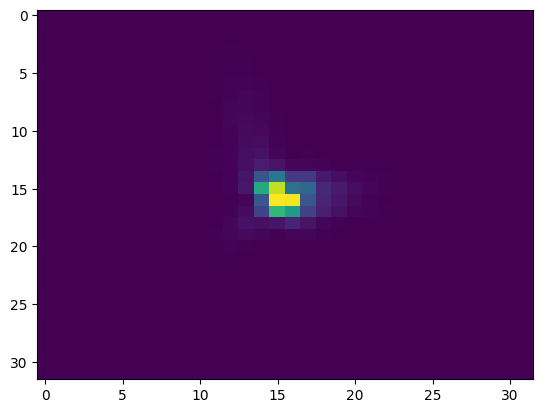

In [37]:
plt.imshow(data_train_FGS[-1,50,:,:].T, aspect = 'auto')

#### Light-curves plot:

Text(0, 0.5, 'Normalized flux in the frame')

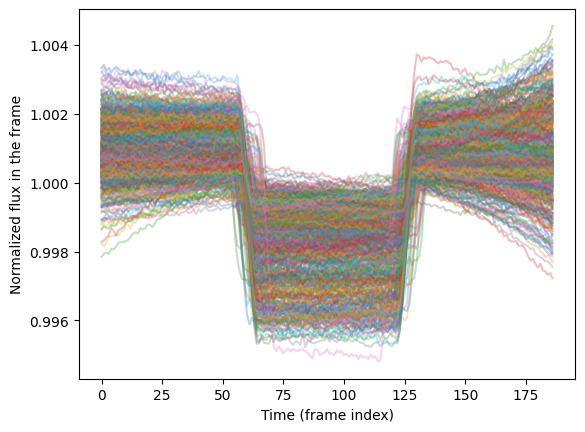

In [38]:
for i in range(len(data_train)) : 
    light_curve = data_train[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')